# The BeachDuneManager module: beach and dune management for coastal communities in CASCADE

In this notebook we illustrate the functionality of the BeachDuneManager module within `CASCADE`. In the BeachDuneManager module, we incorporate beach nourishment and dune management strategies to maintain a coastal community at a fixed cross-shore position. Specifically, we: 
- Widen the beach via nourishment of the shoreface
- Nourish dunes or rebuild following storms
- Remove overwash to account for the filtering effect of development on overwash deposition (Rogers et al., 2015) and place on dunes

These management strategies are employed until the barrier reaches a minimum width and can no longer sustain a community, here defined as the combined width of a single roadway and building footprint (50 m). Thereafter, the community is abandoned and the barrier is allowed to evolve in accordance with the rules and dynamics in Barrier3D. 

For a complete description of the dynamics in the BeachDuneManager module, we direct the user to Anarde et al., (). Here, we seek only to hold your hand and walk you through use of the BeachDuneManager.      

When initializing the BeachDuneManager, the following variables can be specified by the user, with the default values shown below:
```
        - nourishment_interval: None
            Interval that nourishment occurs [yrs]
        - nourishment_volume: 100
            Volume of nourished sand along cross-shore transect [m^3/m]
        - initial_beach_width: 30
            Initial beach width [m]
        - dune_design_elevation: 3.7
            Elevation to which dune is rebuilt to [m MHW]; does not change with RSLR.
        - time_step_count: 500
            Number of time steps.
        - original_growth_param: None
            Dune growth parameters from first time step of barrier3d, before human modifications [unitless]
        - overwash_filter: 40
            Percent overwash removed from barrier interior 
            [40-90% (residential-->commercial) from Rogers et al., 2015]
``` 
Note that when the BeachDuneManager is initialized in `CASCADE`, the initial beach width is calculated based on the user supplied slope and berm elevation.

In the examples below, we initialize `CASCADE` with the default wave climate and dune dynamics (average dune growth rate of 0.45), but increase the rate of sea level rise to 0.007 m/yr and simulate only one 500 m `Barrier3D` domain. All other optional modules are turned off (alongshore sediment transport from `BRIE`, community dynamics from `CHOME`, and roadway management). 

In [1]:
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

datadir = "../B3D_Inputs/"  # laptop 
Path(datadir)
#sys.path.extend(['/Users/KatherineAnardeWheels/PycharmProjects/Barrier3D', '/Users/KatherineAnardeWheels/PycharmProjects/brie', '/Users/KatherineAnardeWheels/PycharmProjects/CASCADE'])
#datadir = "/Users/KatherineAnardeWheels/PycharmProjects/CASCADE/B3D_Inputs/"  # laptop
notebook_dir = "../notebooks/"

from cascade import Cascade
from scripts import CASCADE_plotters as CASCADEplt

## OPTION 1: Nourishment and dune rebuilding at discrete intervals

In this first example, we start by nourishing one Barrier3D domain at discrete intervals, here every 10 years, with a nourishment volume of 100 $m^3/m$, which for the default shoreface and barrier configuration produces about 20 m of shoreline progradation. We do this for 50 years and then change to a 20 year nourishment interval with 300 $m^3/m$ of nourishment volume. We specify that 40% of overwash is filtered by development, which corresponds to the effect of residential buildings in filtering overwash deposition (Rogers et al., 2015) -- see the notebook BeachDuneManager-Overwash_Sensitivity for more details.

**Note that when specifying nourishment at discrete intervals, both the shoreface AND the dune are nourished.**

In [2]:
option1_name= "nourishment_intervals"
iB3D = 0
total_time = 100

cascade = Cascade(
    datadir,
    name=option1_name,
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=3.7,  
    nourishment_interval=10,  # yrs
    nourishment_volume=100, 
    background_erosion=-1.0, # m/yr
    overwash_filter=40,
)


# Loop for 50 years at a 10 year interval, 100 m^3/m and then 50 years at a 20 year interval with 300 m^3/m
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break
        
# during the CASCADE initialization, the nourishment interval and volume is specified individually for each 
# barrier3d alongshore cell; so to update these values, we need to specify which barrier3d cell we want to modify
# (here, we only have one cell)
cascade.nourishment_interval[iB3D] = 20  # increase to 20 years
cascade.nourishment_volume[iB3D] = 300  # increase to 300 m^3/m

for _ in tqdm(range(nt)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

100%|██████████| 50/50 [00:15<00:00,  3.17it/s]


<AxesSubplot:title={'center':'Profile Evolution'}, xlabel='Cross-shore position (dam)', ylabel='Elevation (m MHW)'>

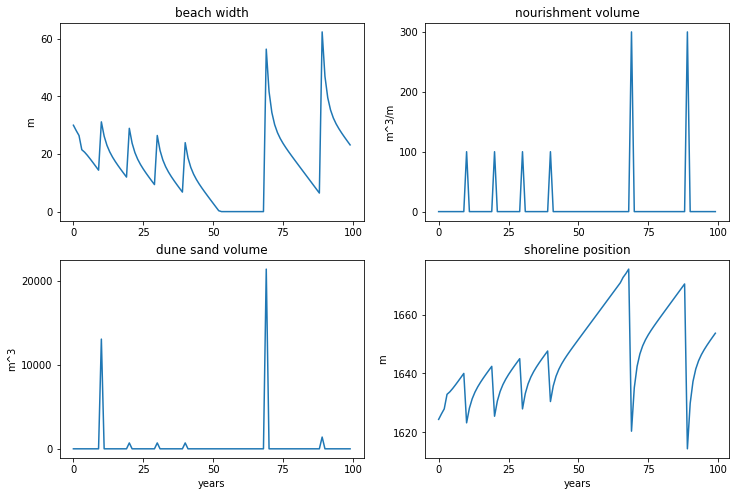

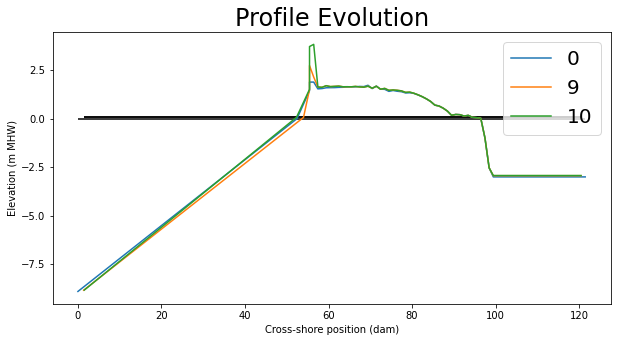

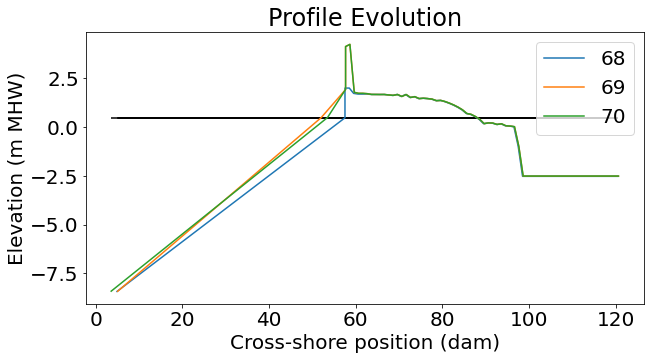

In [3]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")

plt.subplot(2,2,4)
plt.plot(np.array(cascade.barrier3d[iB3D]._x_s_TS) * 10)
plt.title("shoreline position")
plt.ylabel("m")
plt.xlabel("years")

time_step = [0, 9, 10, 68, 69, 70]
CASCADEplt.plot_ModelTransects(cascade, time_step[0:3], iB3D=0)
CASCADEplt.plot_ModelTransects(cascade, time_step[3:6], iB3D=0)
# fig.set_xlim([50,60])
# fig.set_ylim([-1,3])

In the time series figures above, we see that nourishment in the first 50 years (every 10 years at 100 $m^3/m$) cannot keep up with shoreline erosion -- which in this simulation includes that from 0.007 m/yr of sea level rise and from 1 m/yr of background erosion -- resulting in slow erosion of the shoreline. Note that while we allow the beach width to reach zero, an unrealistic phenonmenon, this only implies in the CASCADE framework that dune migration is turned back on and the island is allowed to transgress landward. We can see these dynamics in planform view with the built-in gif plotter:

In [4]:
CASCADEplt.plot_ElevAnimation_Humans_BeachDuneManager(
    cascade, ny=1, directory=notebook_dir, TMAX=100, name=option1_name, TMAX_SIM=100)


[ * GIF successfully generated * ]


In [5]:
gif_dir = notebook_dir + "Output/" + option1_name + "/SimFrames/"
Path(gif_dir)

PosixPath('../notebooks/Output/nourishment_intervals/SimFrames')

![SegmentLocal](../notebooks/Output/nourishment_intervals/SimFrames/elev.gif "segment")

As shown in the gif plotter, we plot an intermediate "0.5 year" timestep, which corresponds to the post-storm barrier configuration *BEFORE* we employ beach and dune management in the BeachDuneManager. These variables are saved to the nourishment module and all begin with "post_storm...". For example, the value for `nourishments[iB3D].post_storm_beach_width[2]` corresponds to the post storm beach width prior to any nourishment decisions during year 2 (i.e., year 1.5). Every variable that is saved to the 1-yr time step in Barrier3D reflects modifications by human management decisions. 

Note that in the above plotter, each cell corresponds to a decameter and therefore the shoreline position and beach widths are rounded and not representative of the actual shoreline position and beach width (however, the evolution of the shoreline and dune migration is correct). We can use another built-in plotter below to view relevant statistics that include the "0.5 year" time step -- including the actual beach width, shoreline position, and dune toe location. This plotter is also particularly insightful for how barrier width, height, and overwash fluxes are altered by our management decisions.

In [ ]:
    (
        BarrierWidth,
        DuneCrestMean,
        BarrierHeight,
        bh_rate,
        bw_rate,
        sc_rate,
        DuneCrestMin,
        DuneCrestMax,
        shoreline_position,
        shoreface_slope,
        beach_width,
        overwash,
    ) = CASCADEplt.plot_nonlinear_stats_BeachDuneManager(
        cascade.barrier3d,
        iB3D,
        tmax_management=100,
        tmax_sim=100,
        nourishments=cascade.nourishments,
        post_storm_dunes=cascade.nourishments[iB3D]._post_storm_dunes,
        post_storm_x_s=cascade.nourishments[iB3D]._post_storm_x_s,
        post_storm_s_sf=cascade.nourishments[iB3D]._post_storm_s_sf,
        post_storm_ave_interior_width=cascade.nourishments[iB3D]._post_storm_ave_interior_width,
        post_storm_ave_interior_height=cascade.nourishments[iB3D]._post_storm_ave_interior_height,
        post_storm_beach_width=cascade.nourishments[iB3D]._post_storm_beach_width,
        post_storm_Qow=cascade.nourishments[iB3D]._post_storm_Qow,
        design_elevation=cascade.nourishments[iB3D]._dune_design_elevation,  # m MHW,
        rebuild_threshold=None,
        dunes_rebuilt=cascade.nourishments[iB3D]._dunes_rebuilt_TS,
    )

The dune dynamics at first glance seem pretty wacky, but if we look at individual figures as part of the gif, we can see that the first line of the dune gets eroded at 56.5 years and the second at 64.5 years, leaving a small foredune, growing at a low rate. The dunes are not rebuilt until the next nourishment at 69 years.

As a check on the dynamics in Barrier3D, here we want to see if the dunes migrate when the beach width goes to zero and the shoreline surpasses a full cell width (10 m). Indeed, dunes only migrate when humans allow them to (beach width = 0), and when the shoreline moves a full cell width -- in year 57 and 65. Note that if one was to check the `post_storm_x_s`, they would find that the dunes actually migrated at 56.5 since dune migration occurrs prior to any human modifications.

In [ ]:
frac_grid_cell = np.array(cascade.barrier3d[iB3D]._x_s_TS) % 1
diff = np.hstack([0,np.diff(frac_grid_cell)])
diff[~np.array(cascade.nourishments[iB3D]._dune_migration_on)] = 0
shoreline_transgressed = diff < 0 
dunes_migrated = cascade.barrier3d[iB3D]._ShorelineChangeTS < 0
print("Indices for when dunes migrated = ", np.where(dunes_migrated)[0])
print("Indices for when shoreline transgressed = ", np.where(shoreline_transgressed)[0])
# shoreline_transgressed == dunes_migrated  # for pytest

## OPTION 2: Nourishment and dune rebuilding based on user indicators

The section option for shoreface nourishment and dune rebuilding is based on user supplied indicators. Here, we trigger nourishment using the `nourish_now` parameter after the beach width reaches a minimum beach width (30 m). The dune is rebuilt using the `rebuild_dune_now` parameter only when the dune reaches a minimum dune height (0.3 m above the berm elevation). Recall that sand volumes are added to the dune after storms up to a maximum height ()

In [ ]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_test",
    sea_level_rise_rate=0.007,
    alongshore_section_count=1,
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=False,
    dune_design_elevation=3.7,  # dune rebuilt to this height when specified
    nourishment_interval=None,  # yrs
    nourishment_volume=100,  # m^3/m 
    background_erosion=-1.0, # m/yr
    overwash_filter=40,
)
    
# loop for 100 years, but after each year, check the beach width and dune height and decide if you want to nourish
# or rebuild dune the next year with trigger parameter
nt = 100
bw_threshold = 30  
dune_threshold = 0.3 + (
        cascade.barrier3d[iB3D].BermEl * 10
    )  # same threshold for absolute minimum elevation as in RoadwayManager (m MHW)

for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.b3d_break:
        break

    # stop managing if the barrier becomes too narrow to sustain a community
    if cascade.community_break:
        pass
    else:
        t = cascade.barrier3d[iB3D].time_index

        if cascade.nourishments[iB3D].beach_width[t - 1] < bw_threshold:
            cascade.nourish_now[iB3D] = 1

        DuneDomainCrest = (
            cascade.barrier3d[iB3D].DuneDomain[t - 1, :, :].max(axis=1)
        )  # Maximum height of each row in dune domain [dam]
        DuneCrestMin = (
            np.min(DuneDomainCrest) + cascade.barrier3d[iB3D].BermEl
        ) * 10  # m MHW

        if DuneCrestMin < dune_rebuild_threshold:
            cascade.rebuild_dune_now[iB3D] = 1

In [ ]:
    (
        BarrierWidth,
        DuneCrestMean,
        BarrierHeight,
        bh_rate,
        bw_rate,
        sc_rate,
        DuneCrestMin,
        DuneCrestMax,
        shoreline_position,
        shoreface_slope,
        beach_width,
        overwash,
    ) = CASCADEplt.plot_nonlinear_stats_BeachDuneManager(
        cascade.barrier3d,
        iB3D,
        tmax_management=100,
        tmax_sim=100,
        nourishments=cascade.nourishments,
        post_storm_dunes=cascade.nourishments[iB3D]._post_storm_dunes,
        post_storm_x_s=cascade.nourishments[iB3D]._post_storm_x_s,
        post_storm_s_sf=cascade.nourishments[iB3D]._post_storm_s_sf,
        post_storm_ave_interior_width=cascade.nourishments[iB3D]._post_storm_ave_interior_width,
        post_storm_ave_interior_height=cascade.nourishments[iB3D]._post_storm_ave_interior_height,
        post_storm_beach_width=cascade.nourishments[iB3D]._post_storm_beach_width,
        post_storm_Qow=cascade.nourishments[iB3D]._post_storm_Qow,
        design_elevation=cascade.nourishments[iB3D]._dune_design_elevation,  # m MHW,
        rebuild_threshold=None,
        dunes_rebuilt=cascade.nourishments[iB3D]._dunes_rebuilt_TS,
    )

LEFT OFF HERE: So why did the nourishment volume go less far with the nourishment post storm at 46 years?

In [ ]:
time_step = [0,1,2]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([40,70])
# fig.set_ylim([-1,3])

time_step = [44, 45, 46]
fig = CASCADE_Plt.plot_ModelTransects(cascade, time_step, iB3D=0)
# fig.set_xlim([50,60])

In [ ]:
time_step = [45,46]
sea_level = cascade.barrier3d[iB3D]._SL  # always zero
y_shoreface = 0  # also doesn't change
# y_shoreface = (sea_level - cascade.barrier3d[iB3D].DShoreface) * 10  # also doesn't change
x_shoreface = cascade.barrier3d[iB3D]._x_t_TS 
x_shoreline = cascade.barrier3d[iB3D]._x_s_TS
# y_shoreline = sea_level
y_shoreline = cascade.barrier3d[iB3D].DShoreface * 10

area_pre_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[0]]*10, x_shoreline[time_step[0]]*10])
area_post_nourish = np.trapz([y_shoreface,y_shoreline], x=[x_shoreface[time_step[1]]*10, x_shoreline[time_step[1]]*10])
area_pre_nourish-area_post_nourish

Now that I've integrated, I'm not sure what it tells us...If we look at the equation for change in shoreline position, the only thing that differs between the two nourishments is barrier height! Create a block diagram explaining the nourishment geometry claculation. This will help explain this phenomenon.

## OPTION 3: Nourishment and dune rebuilding based on CHOME (community dynamics)

Short explanation on how nourishment and dune rebuilding/management are decided in CHOME, and how the models are coupled. Also explain new CHOME variables. Otherwise, use same inputs as above to compare!

In [ ]:
iB3D = 0
total_time = 100
cascade = Cascade(
    datadir,
    name="nourish_now_test",
    sea_level_rise_rate=0.007,
    alongshore_section_count=3,  
    time_step_count=total_time,
    num_cores=1,
    roadway_management_module=False,
    alongshore_transport_module=False,
    beach_nourishment_module=True,
    community_dynamics_module=True,
    dune_design_elevation=3.7, 
    nourishment_interval=None,  
    nourishment_volume=100,  # set by CHOME, dummy variable
    number_of_communities=1, 
    sand_cost=10,
    taxratio_oceanfront=1,
    external_housing_market_value_oceanfront=6e5,
    external_housing_market_value_nonoceanfront=4e5,
    fixed_cost_beach_nourishment=2e6,
    fixed_cost_dune_nourishment=2e5,
    nourishment_cost_subsidy=10e6,
    house_footprint=15,
)

# Loop for 50 years 
nt = 50
for _ in tqdm(range(nt-1)):
    cascade.update()
    if cascade.road_break or cascade.b3d_break:
        break

In [ ]:
fig=plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(cascade.nourishments[iB3D].beach_width)
plt.title("beach width")
plt.ylabel("m")

plt.subplot(2,2,2)
plt.plot(cascade.nourishments[iB3D]._nourishment_volume_TS)
plt.title("nourishment volume")
plt.ylabel("m^3/m")
plt.xlabel("years")

plt.subplot(2,2,3)
plt.plot(cascade.nourishments[iB3D]._rebuild_dune_volume_TS)
plt.title("dune sand volume")
plt.ylabel("m^3")
plt.xlabel("years")
fig.tight_layout()